In [1]:
%pylab inline
import warnings
# warnings.filterwarnings('ignore')
import pandas as pd
import xarray as xr
import glob, re, os
import scipy
from scipy import io, optimize
import pickle
import datetime
# import netCDF4
# import pygrib
import resource
## For debug mode
from IPython.core.debugger import Tracer
#Tracer()() #this one triggers the debugger

Populating the interactive namespace from numpy and matplotlib


In [2]:
ds = xr.open_dataset('/net/san-b8-ib/data/gpm/a/shared/szhu28/hiwcproc/darwin/ecmwf.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:                              (lat: 43, level: 37, lon: 71, timemod: 236)
Coordinates:
  * timemod                              (timemod) datetime64[ns] 2014-01-01 ...
  * level                                (level) float64 1.0 2.0 3.0 5.0 7.0 ...
  * lat                                  (lat) float64 9.474 8.772 8.07 ...
  * lon                                  (lon) float64 110.4 111.1 111.8 ...
Data variables:
    Potential vorticity                  (timemod, level, lat, lon) float64 0.00081 ...
    Geopotential                         (timemod, level, lat, lon) float64 4.657e+05 ...
    Temperature                          (timemod, level, lat, lon) float64 258.2 ...
    Specific humidity                    (timemod, level, lat, lon) float64 4.009e-06 ...
    Vertical velocity                    (timemod, level, lat, lon) float64 -0.0006067 ...
    Vorticity (relative)                 (timemod, level, lat, lon) float64 2.343e-06 ...
    Divergence     

In [4]:
haha = ds.sel(timemod=pd.Timestamp('201402030500'),lon=111,lat=-5,method='nearest')

In [5]:
haha=haha.where((haha.Temperature>-60+273.15)&(haha.Temperature<-10+273.15)&(haha.Geopotential<13e4))
# haha=haha.where(haha.Temperature<-10+273.15)
# haha=haha.where(haha.Geopotential<13e4)

/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/data/keeling/a/szhu28/usr/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


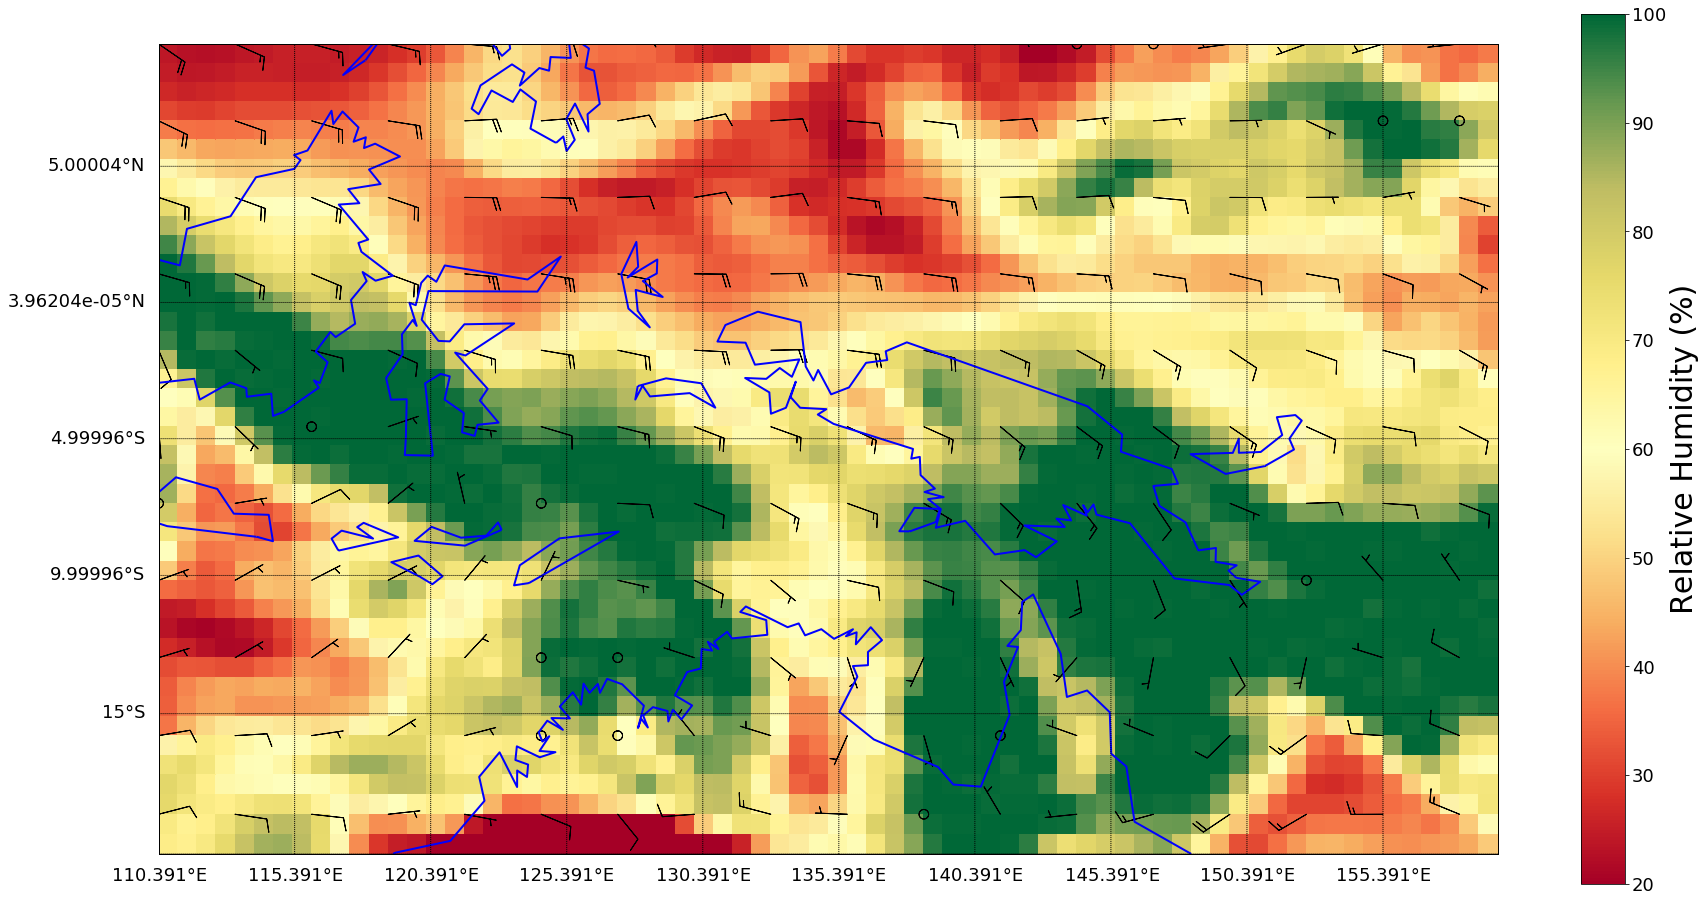

In [4]:
# Code from Jeff Thayer
# load ECMWF grib1 data from Keeling
# grib_path_bulk = '/data/dhence/a/jthayer2/Data/ERA-Interim/pres_levels/201110/ei.oper.an.pl.regn128sc.2011103000.grb' #bulk of variables
# grib_path_winds = '/data/dhence/a/jthayer2/Data/ERA-Interim/pres_levels/201110/ei.oper.an.pl.regn128uv.2011103000.grb'

# # actually load the grib1 data into python
# grib_file_bulk = pygrib.open(grib_path_bulk)
# grib_file_winds = pygrib.open(grib_path_winds)


##Relative Humidity and Winds

import matplotlib.cm as cm
import matplotlib.colors as col
from mpl_toolkits.basemap import Basemap
#cdict = cm.get_cmap('RdYlGn')._segmentdata

#cdict['green'][6] = (0.6, 0.81, 0.81)

my_RH_cdict = {'red': [(0.0, 0.6470588445663452, 0.6470588445663452),
                       (0.1, 0.843137264251709, 0.843137264251709),
                       (0.2, 0.95686274766922, 0.95686274766922),
                       (0.3, 0.97, 0.97),
                       (0.4, 0.985, 0.985),
                       (0.5, 0.995, 0.995),
                       (0.6, 1.0, 1.0),
                       (0.7, 0.9, 0.9),
                       (0.8, 0.75, 0.75),
                       (0.9, 0.4, 0.4),
                       (1.0, 0.0, 0.0)],
 
             'green': [(0.0, 0.0, 0.0),
                       (0.1, 0.1882352977991104, 0.1882352977991104),
                       (0.2, 0.4274509847164154, 0.4274509847164154),
                       (0.3, 0.6823529601097107, 0.6823529601097107),
                       (0.4, 0.8784313797950745, 0.8784313797950745),
                       (0.5, 1.0, 1.0),
                       (0.6, 0.9372549057006836, 0.9372549057006836),
                       (0.7, 0.8509804010391235, 0.8509804010391235),
                       (0.8, 0.7411764860153198, 0.7411764860153198),
                       (0.9, 0.5960784554481506, 0.5960784554481506),
                       (1.0, 0.40784314274787903, 0.40784314274787903)],
 
              'blue': [(0.0, 0.14901961386203766, 0.14901961386203766),
                       (0.1, 0.15294118225574493, 0.15294118225574493),
                       (0.2, 0.26274511218070984, 0.26274511218070984),
                       (0.3, 0.3803921639919281, 0.3803921639919281),
                       (0.4, 0.545098066329956, 0.545098066329956),
                       (0.5, 0.7490196228027344, 0.7490196228027344),
                       (0.6, 0.545098066329956, 0.545098066329956),
                       (0.7, 0.4156862795352936, 0.4156862795352936),
                       (0.8, 0.38823530077934265, 0.38823530077934265),
                       (0.9, 0.3137255012989044, 0.3137255012989044),
                       (1.0, 0.21568627655506134, 0.21568627655506134)]}

my_RH_cmap = col.LinearSegmentedColormap('my_colormap', my_RH_cdict)


fig1 = plt.figure(figsize=(30,16))

#########################################################################
## 850mb
#ax5 = fig3.add_subplot(122)

# grb_Uwinds_850 = grib_file_winds.select(name = 'U component of wind')[30]
mylevel = 250
mytime = pd.Timestamp('201402030500')
grb_Uwinds_850 = ds['U component of wind'].sel(timemod=mytime,level=mylevel,method='nearest')
grb_Vwinds_850 = ds['V component of wind'].sel(timemod=mytime,level=mylevel,method='nearest')
# grb_Vwinds_850 = grib_file_winds.select(name = 'V component of wind')[30]
# grb_RH_850 = grib_file_bulk.select(name = 'Relative humidity')[30]
grb_RH_850 = ds['Relative humidity'].sel(timemod=mytime,level=mylevel,method='nearest')

u_850 = grb_Uwinds_850.values
v_850 = grb_Vwinds_850.values
RH_850 = grb_RH_850.values

# u_850_kts = u_850 #Convert from m/s to kts
# v_850_kts = v_850

# lats_winds, lons_winds = grb_Uwinds_850.latlons()
lat = ds.lat.values
lon = ds.lon.values
# lats_winds, lons_winds = np.meshgrid(ds.lon.values,ds.lat.values)
lons_winds, lats_winds = np.meshgrid(ds.lon.values,ds.lat.values)
lats_bulk, lons_bulk = lats_winds, lons_winds
# lats_bulk, lons_bulk = grb_RH_850.latlons()

#ax5.set_title('850 hPa', fontsize=40)
m=Basemap(llcrnrlon=np.min(lon),llcrnrlat=np.min(lat),urcrnrlon=np.max(lon),urcrnrlat=np.max(lat),projection='mill')

m.drawmapboundary()
m.drawcoastlines(linewidth=2, color='b')
parallels = np.arange(np.min(lat),np.max(lat),5.)
meridians = np.arange(np.min(lon),np.max(lon),5.)
m.drawparallels(parallels,labels=[True,False,False,False], fontsize=18)
m.drawmeridians(meridians,labels=[False,False,False,True], fontsize=18)
#m.drawparallels(parallels,labels=[False,True,False,False], fontsize=18)
#m.drawmeridians(meridians,labels=[False,False,False,True], fontsize=18)
# m.fillcontinents(color='0.8')
# x1,y1 = m(70.313, -3.157)
# x2,y2 = m(70.313, 1.754)
# x3,y3 = m(75.234, 1.754)
# x4,y4 = m(75.234, -3.154)
# poly = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],facecolor='none',edgecolor='black',linewidth=5)
# plt.gca().add_patch(poly)
# lon_Gan = 73.155
# lat_Gan = -0.694
# x_Gan,y_Gan = m(lon_Gan, lat_Gan)
# m.plot(x_Gan, y_Gan, 'ko', markersize=18)

x_bulk,y_bulk = m(lats_bulk, lons_bulk)

x_winds,y_winds = m(lats_winds, lons_winds)
urot,vrot,x_winds,y_winds = m.rotate_vector(u_850[::4,::4],
                                v_850[::4,::4],
                                lons_winds[::4,::4],lats_winds[::4,::4],returnxy=True)

x_winds2,y_winds2 = m(lats_winds, lons_winds)
urot2,vrot2,x_winds2,y_winds2 = m.rotate_vector(u_850[::1,::1],
                                v_850[::1,::1],
                                lons_winds[::1,::1],lats_winds[::1,::1],returnxy=True)
                                
s = m.pcolormesh(x_winds2,y_winds2,RH_850[::1,::1],cmap=my_RH_cmap)
plt.clim([20,100])
#cbar=fig3.colorbar(s,shrink=0.5)
cbar=fig1.colorbar(s)
cbar.set_label('Relative Humidity (%)', fontsize=30)
cbar.ax.tick_params(labelsize=18)

B = plt.barbs(x_winds,y_winds,urot,vrot, length=8, flagcolor='k',barbcolor=['k', 'k'])



In [33]:
hehe

<xarray.DataArray 'Vertical velocity' (level: 37)>
array([ -5.647012e-04,  -3.214702e-04,   8.998141e-04,  -2.682544e-04,
        -1.027115e-03,  -1.018334e-03,  -1.043301e-03,   1.027953e-03,
        -4.121840e-03,   2.899110e-03,  -2.220660e-02,  -1.005526e-01,
        -1.626670e-01,  -1.895357e-01,  -1.932837e-01,  -1.953845e-01,
        -2.155676e-01,  -2.937546e-01,  -3.924837e-01,  -4.075375e-01,
        -3.695736e-01,  -3.164625e-01,  -2.619972e-01,  -2.517662e-01,
        -3.239450e-01,  -4.457502e-01,  -5.779953e-01,  -6.073465e-01,
        -6.043215e-01,  -5.757046e-01,  -5.200872e-01,  -4.352026e-01,
        -3.286037e-01,  -1.975498e-01,  -6.568623e-02,   5.255711e-02,
         8.180624e-02])
Coordinates:
    timemod  datetime64[ns] 2014-02-03T06:00:00
  * level    (level) float64 1.0 2.0 3.0 5.0 7.0 10.0 20.0 30.0 50.0 70.0 ...
    lat      float64 -15.09
    lon      float64 128.7
Attributes:
    units:    Pa s**-1

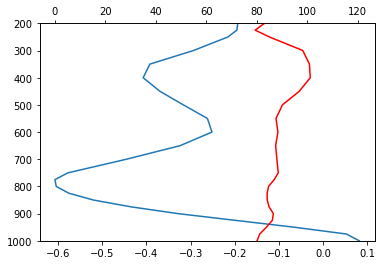

In [6]:
hehe = ds['Vertical velocity'].sel(timemod=pd.Timestamp('201402030500'),lon=129,lat=-15,method='nearest')
hihi = ds['Relative humidity'].sel(timemod=pd.Timestamp('201402030500'),lon=129,lat=-15,method='nearest')

fig, ax = subplots()
ax.plot(hehe.values,hehe.level)
ax2 = ax.twiny()
ax2.plot(hihi.values,hehe.level,'r')
plt.ylim(200,1000)
plt.gca().invert_yaxis()

In [10]:
ds

<xarray.Dataset>
Dimensions:                              (lat: 43, level: 37, lon: 71, timemod: 236)
Coordinates:
  * timemod                              (timemod) datetime64[ns] 2014-01-01 ...
  * level                                (level) float64 1.0 2.0 3.0 5.0 7.0 ...
  * lat                                  (lat) float64 9.474 8.772 8.07 ...
  * lon                                  (lon) float64 110.4 111.1 111.8 ...
Data variables:
    Potential vorticity                  (timemod, level, lat, lon) float64 0.00081 ...
    Geopotential                         (timemod, level, lat, lon) float64 4.657e+05 ...
    Temperature                          (timemod, level, lat, lon) float64 258.2 ...
    Specific humidity                    (timemod, level, lat, lon) float64 4.009e-06 ...
    Vertical velocity                    (timemod, level, lat, lon) float64 -0.0006067 ...
    Vorticity (relative)                 (timemod, level, lat, lon) float64 2.343e-06 ...
    Divergence     

(0, 14000)

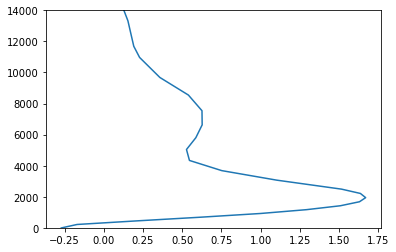

In [16]:
dss = ds.sel(timemod=pd.Timestamp('201402030600'),lon=129,lat=-15,method='nearest')
plt.plot((-dss['Vertical velocity']*dss['level']/dss['Temperature']),dss['Geopotential']/9.8)
plt.ylim([0,14000])

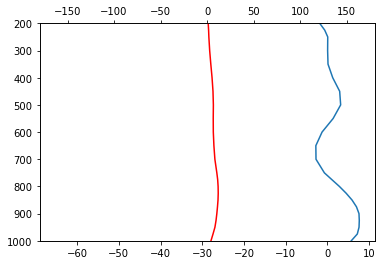

In [9]:
hehe = ds['U component of wind'].sel(timemod=pd.Timestamp('201402030600'),lon=129,lat=-15,method='nearest')
hihi = ds['V component of wind'].sel(timemod=pd.Timestamp('201402030600'),lon=129,lat=-15,method='nearest')
# hehe = ds['U component of wind'].sel(timemod=pd.Timestamp('201402030500'),lon=150,lat=5,method='nearest')
# hihi = ds['V component of wind'].sel(timemod=pd.Timestamp('201402030500'),lon=150,lat=5,method='nearest')

# hehe,hihi = np.sqrt(hehe**2+hihi**2), np.arctan2(hihi,hehe)*180/np.pi
fig, ax = subplots()
ax.plot(hehe.values,hehe.level)
ax2 = ax.twiny()
ax2.plot(hihi.values,hehe.level,'r')
plt.ylim(200,1000)
ax2.set_xlim(-180,180)
plt.gca().invert_yaxis()